In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Could not load julia package 'bad', make sure julia is found and 'bad' is installed. Try running 'badr::load_julia_package()' with optional arguments for 'JuliaCall::julia_setup()' to install.


In [2]:
p0    <- .2
alpha <- .05
p1    <- .4
beta  <- .2
mcr   <- .3

prior <- (0.2*Beta(1, 1) + 0.8*Beta_mu_sd(.35, .1) ) <= 0.7

In [3]:
design <- Problem(
        minimise( SampleSize(prior) ),
        Power(prior %|% p0) <= alpha,
        Power(prior >= mcr) >= 1 - beta,
        label = 'pragmatic prior'
    ) %>%
    optimise_design(verbosity = 0)

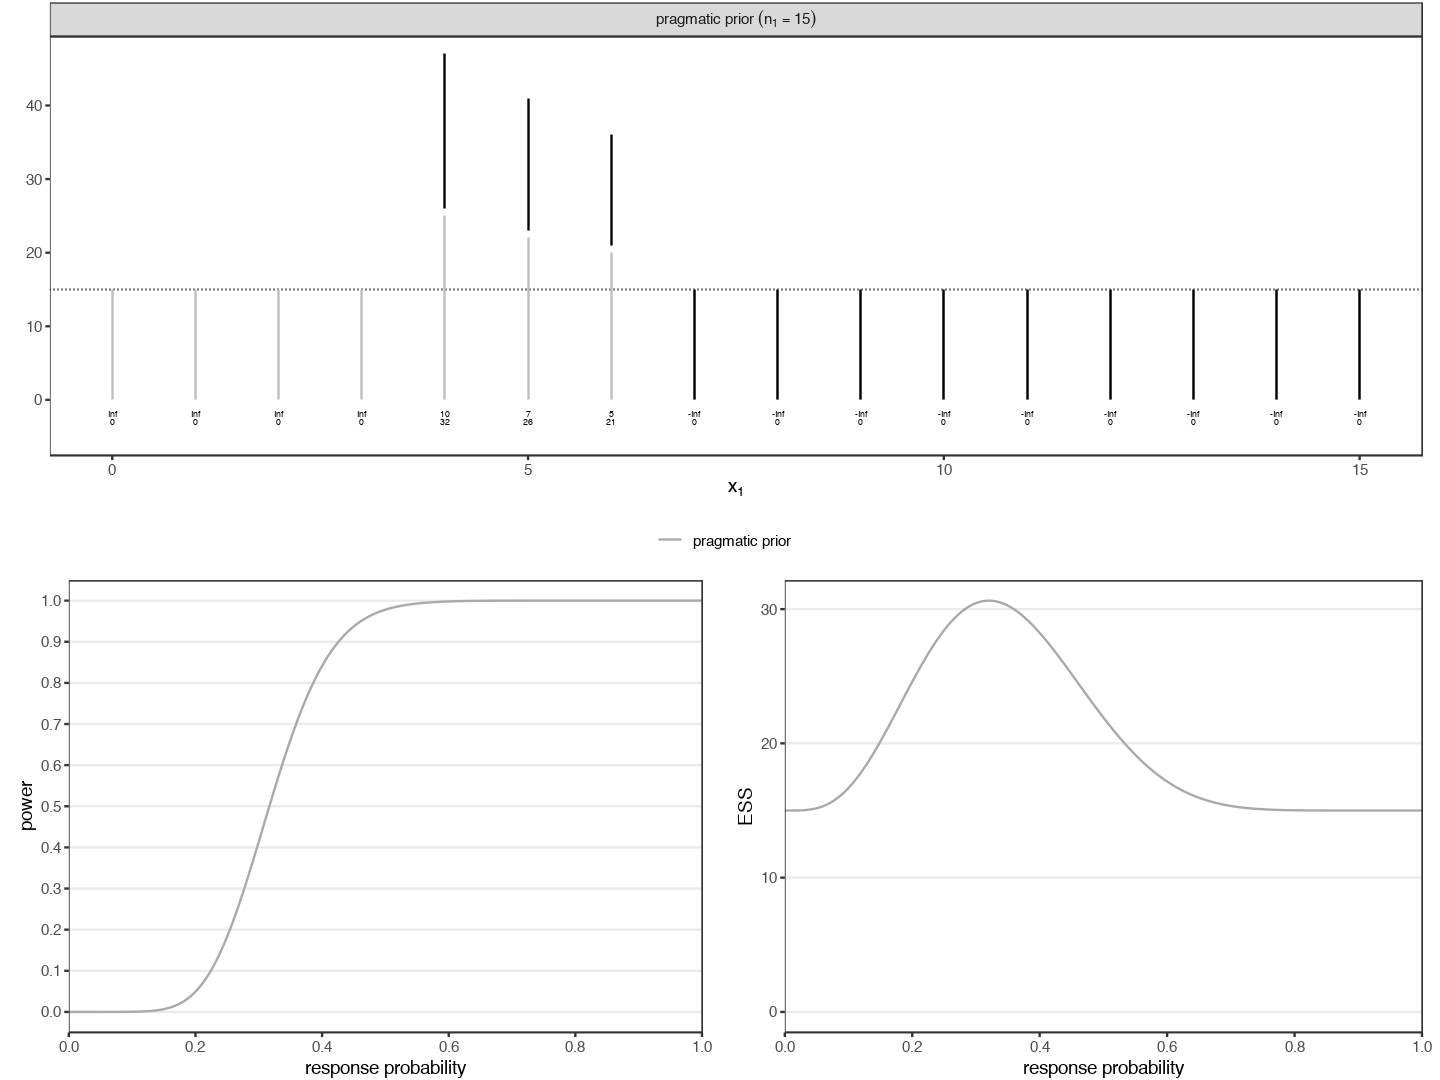

In [4]:
options(repr.plot.width = 12, repr.plot.height = 9)

design_plot <- plot_compare_designs(
    design, 
    args_design_plot = list(yexpandlower = .125)
)

design_plot

In [5]:
jeffreys_prior <- JeffreysPrior(design)
uniform        <- Beta(1, 1)
naive_jeffreys <- Beta(.5, .5)

In [6]:
get_point_estimator_performance <- function(prior) {
    tibble(
        p       = seq(0, 1, .01),
        density = density(prior, p),
        bias    = bias(p, PosteriorMean(prior), design),
        RMSE    = sqrt(mean_squared_error(p, PosteriorMean(prior), design))
    )
}

In [7]:
tbl_point_estimator_performance <- tibble(
        prior = list(prior, Beta(1, 1), Beta(.5, .5), jeffreys_prior),
        label = c("pragmatic", "uniform", "Beta(0.5,0.5)", "Jeffreys"),
    ) %>%
    mutate(
        data = map(prior, get_point_estimator_performance)
    ) %>%
    unnest(data) %>%
    group_by(label) %>%
    pivot_longer(c(bias, RMSE)) %>%
    ungroup()

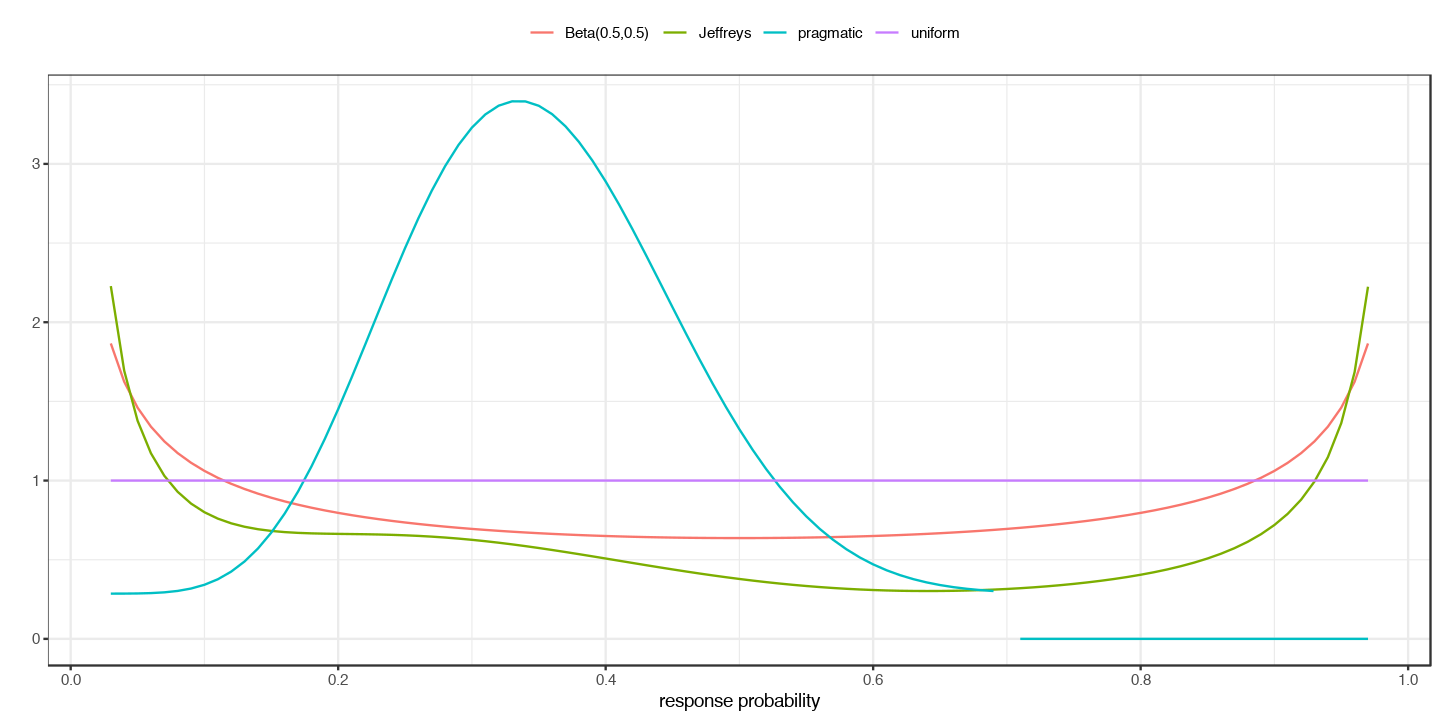

In [8]:
options(repr.plot.width = 12, repr.plot.height = 6)


plt_priors <- ggplot(
        tbl_point_estimator_performance %>%
            # density informatio is repeated 
            filter(name == 'bias', between(p, .025, .975)) %>%
            # make sure we get discontinuity for composite prior 
            mutate(density = ifelse(
                (label == 'pragmatic') & between(p, .699, .701),
                NA_real_, density)
            )
    ) +
    aes(p, density, color = label) +
    geom_line() +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('') +
    scale_color_discrete('') +
    theme_bw() +
    theme(
        legend.position = 'top'
    )

plt_priors

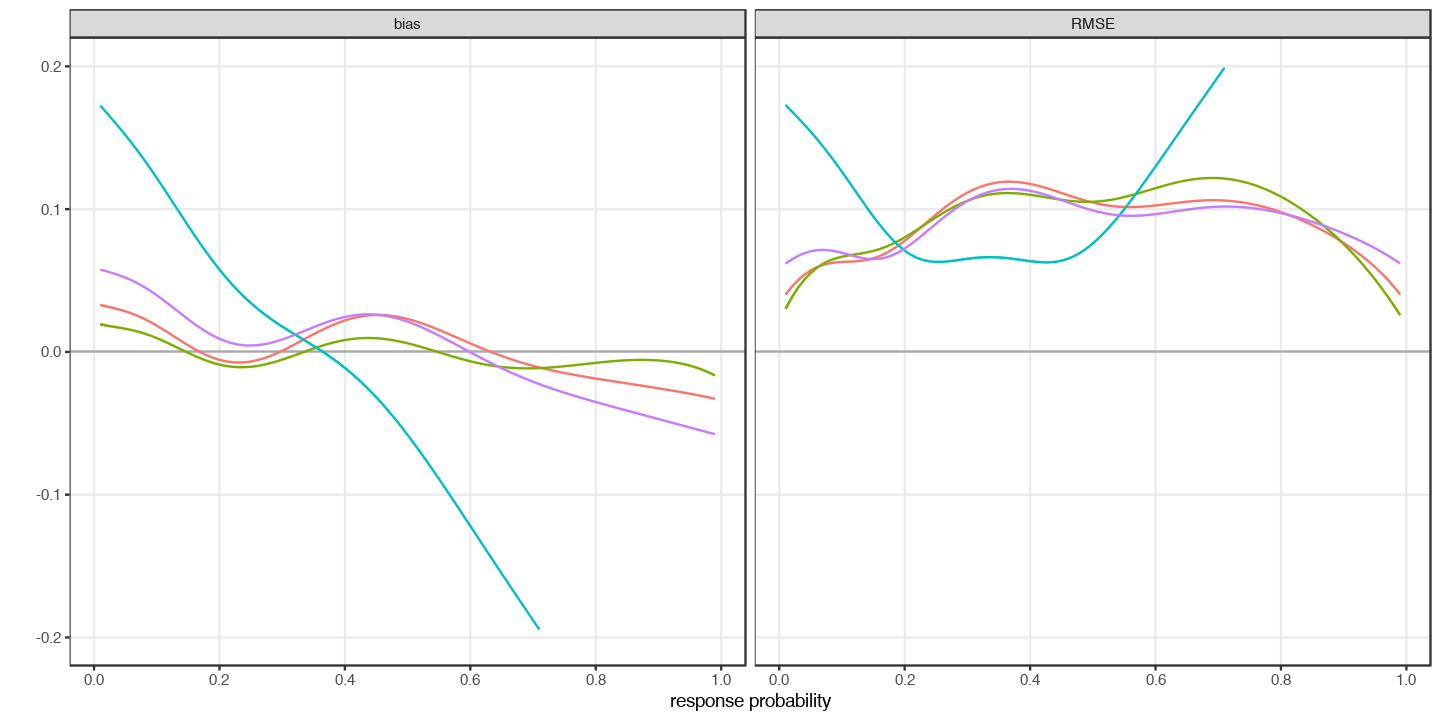

In [9]:
options(repr.plot.width = 12, repr.plot.height = 6)


plt_performance_comparison <- ggplot(
        tbl_point_estimator_performance %>% 
        filter(
            between(p, .01, .99), # cut boundaries
            between(value, -0.2, 0.2) # cut extreme deviations 
        )
    ) +
    aes(p, value, color = label) +
    geom_hline(yintercept = 0, color = 'darkgray') +
    geom_line() +
    geom_line(aes(alpha = density)) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('', limits = c(-.2, .2)) +
    scale_color_discrete('') +
    scale_alpha_continuous('', range = c(0, 1), guide = 'none') +
    facet_wrap(~name) +
    theme_bw() +
    theme(
        legend.position = 'none',
        panel.grid.minor = element_blank()
    )

plt_performance_comparison

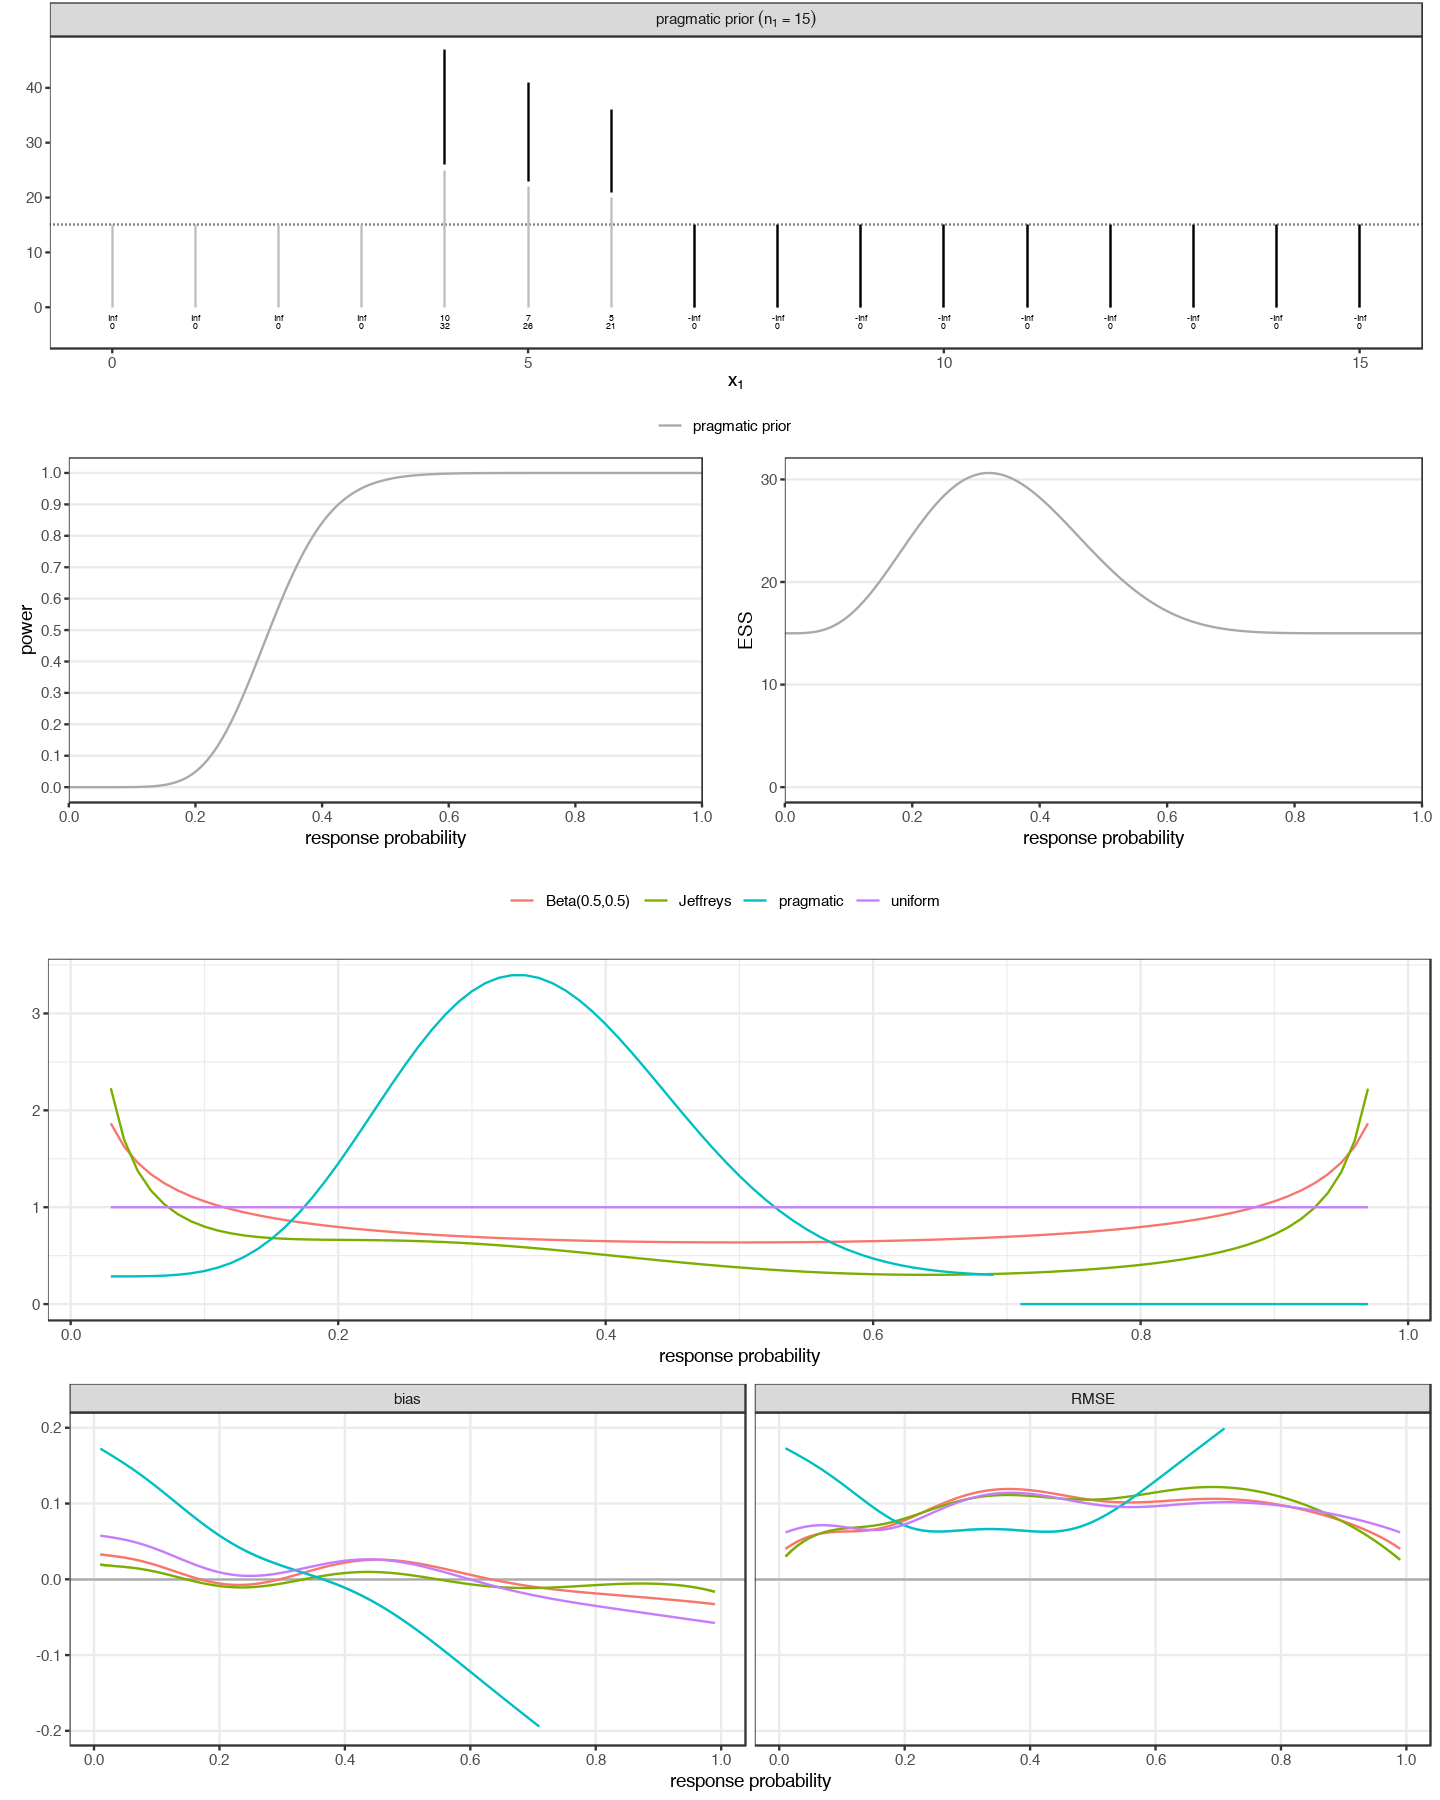

In [10]:
options(repr.plot.width = 12, repr.plot.height = 15)

cowplot::plot_grid(
    design_plot, 
    cowplot::get_legend(plt_priors), 
    plt_priors + theme(legend.position = 'none'), 
    plt_performance_comparison,
    ncol = 1, 
    rel_heights = c(6, .7, 3, 3)
)

In [11]:
ggsave("bayesian-inference-posterior-mean-bias-rmse.pdf", width = 7, height = 9)

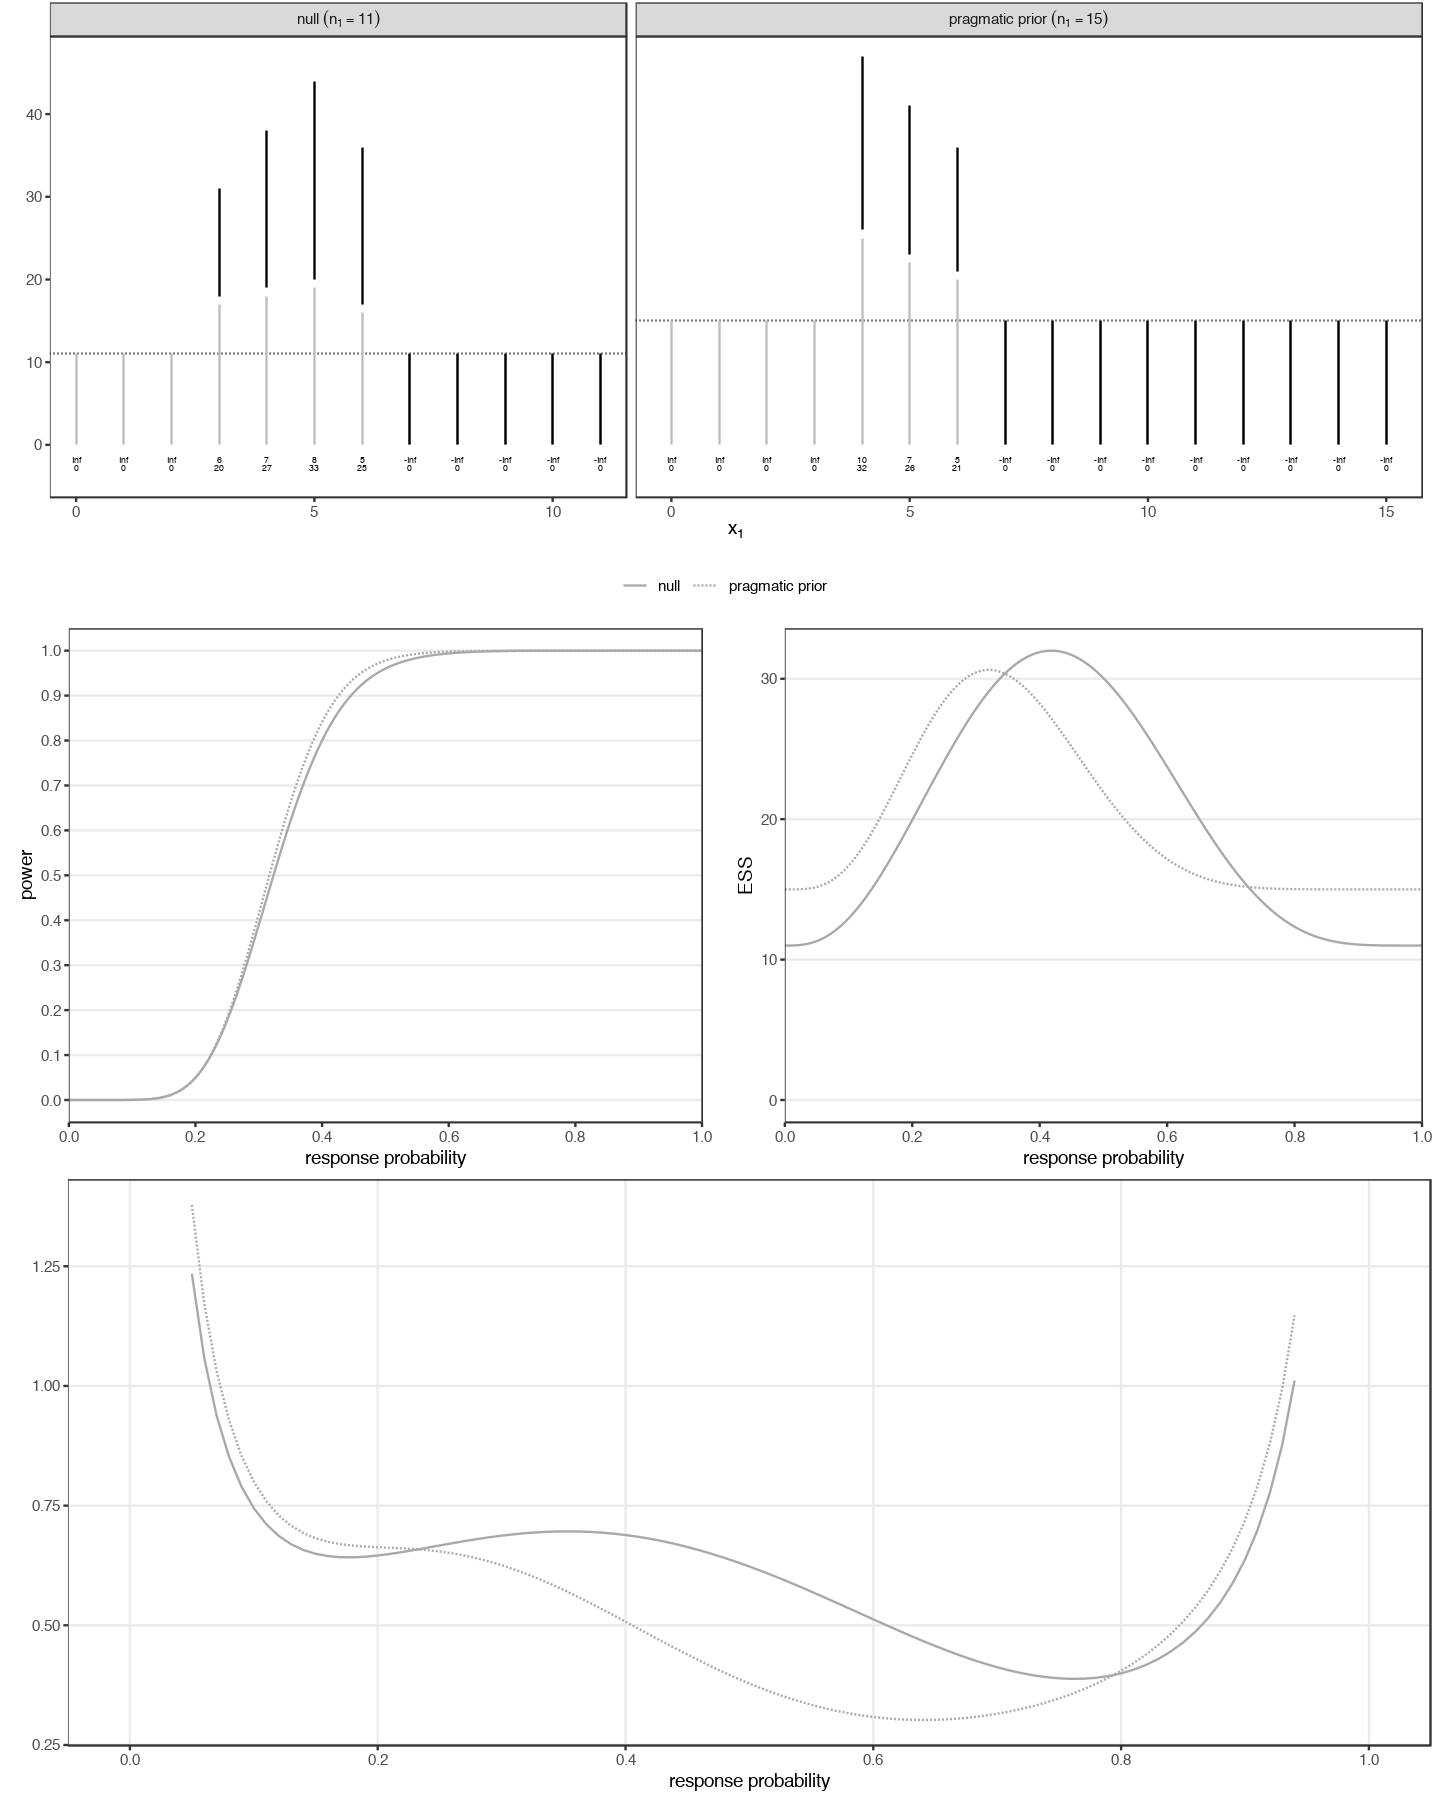

In [12]:
design_h0 <- Problem(
        minimise(SampleSize(prior %|% p0)),
        Power(prior %|% p0) <= alpha,
        Power(prior %|% p1) >= 1 - beta,
        label = 'null',
        unimodal = TRUE
    ) %>%
    optimise_design()

plt_design <- plot_compare_designs(design, design_h0)

tbl_plot <- tibble(
        prior = list(JeffreysPrior(design), JeffreysPrior(design_h0)),
        label = c("pragmatic", "null"),
    ) %>%
    mutate(
        data = map(prior, get_point_estimator_performance)
    ) %>%
    unnest(data) %>%
    select(prior, label, p, density)

priors <- ggplot(tbl_plot %>% filter(between(p, .05, .95))) +
    aes(p, density, linetype = label) +
    geom_line(color = 'darkgray') +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2), limits = c(0, 1)) +
    scale_y_continuous('') +
    scale_color_discrete('') +
    theme_bw() +
    theme(
        legend.position = 'top',
        panel.grid.minor = element_blank()
    )

legend <- cowplot::get_legend(priors)

cowplot::plot_grid(
    plt_design, priors + theme(legend.position = 'none'),
    ncol = 1, rel_heights = c(6.5, 3.5)
)

In [13]:
ggsave("bayesian-inference-jeffreys-prior.pdf", width = 7, height = 8)